# Trabalho A2 - Análise de Séries Temporais

## Bibliotecas

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.linear_model import LinearRegression
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sklearn.model_selection import TimeSeriesSplit
from sktime.performance_metrics.forecasting import (
    mean_absolute_error, mean_squared_error,
    mean_absolute_percentage_error, MeanAbsoluteScaledError,
)

from scipy.stats import boxcox
from scipy.special import inv_boxcox

import itertools

## Dados

In [50]:
prison = pd.read_csv("data_updated.csv")

In [51]:
prison

,week,volume,inv,users
0,2022-10-31,0.38,1.609882,6.500
1,2022-11-07,0.47,1.880548,7.061
2,2022-11-14,0.32,2.297810,5.875
3,2022-11-21,1.69,5.623875,24.238
4,2022-11-28,1.23,1.473418,7.648
...,...,...,...,...
152,2025-09-29,20.33,1.144344,9.575
153,2025-10-06,14.50,0.520285,4.504
154,2025-10-13,17.89,0.837998,7.296
155,2025-10-20,24.52,1.422242,12.458


In [25]:
# Converte a coluna "week" para datetime
prison["week"] = pd.to_datetime(prison["week"])

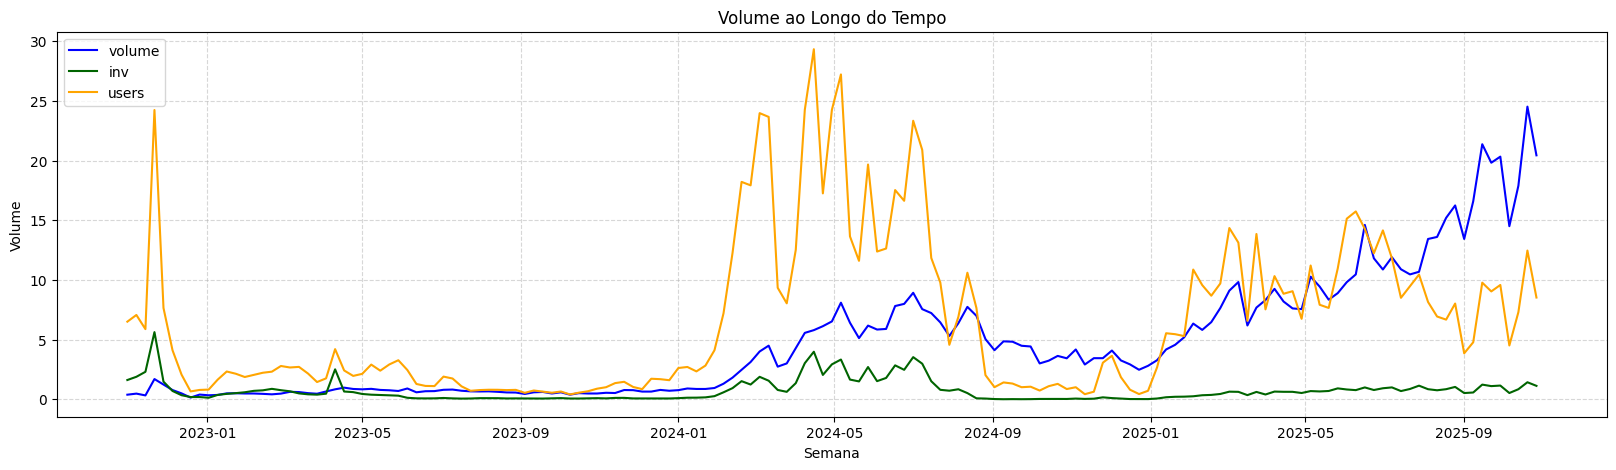

In [26]:
# Criar o gráfico
plt.figure(figsize=(20, 5))
plt.plot(prison["week"], prison["volume"], linestyle="-", marker="", color="blue", label="volume")
plt.plot(prison["week"], prison["inv"], linestyle="-", marker="", color="darkgreen", label="inv")
plt.plot(prison["week"], prison["users"], linestyle="-", marker="", color="orange", label="users")

# Labels e título
plt.xlabel("Semana")
plt.ylabel("Volume")
plt.title("Volume ao Longo do Tempo")
plt.legend(loc="upper left")

# Estilo minimalista
plt.grid(True, linestyle="--", alpha=0.5)
# plt.tight_layout()
plt.show()

Plots de cada variável separada

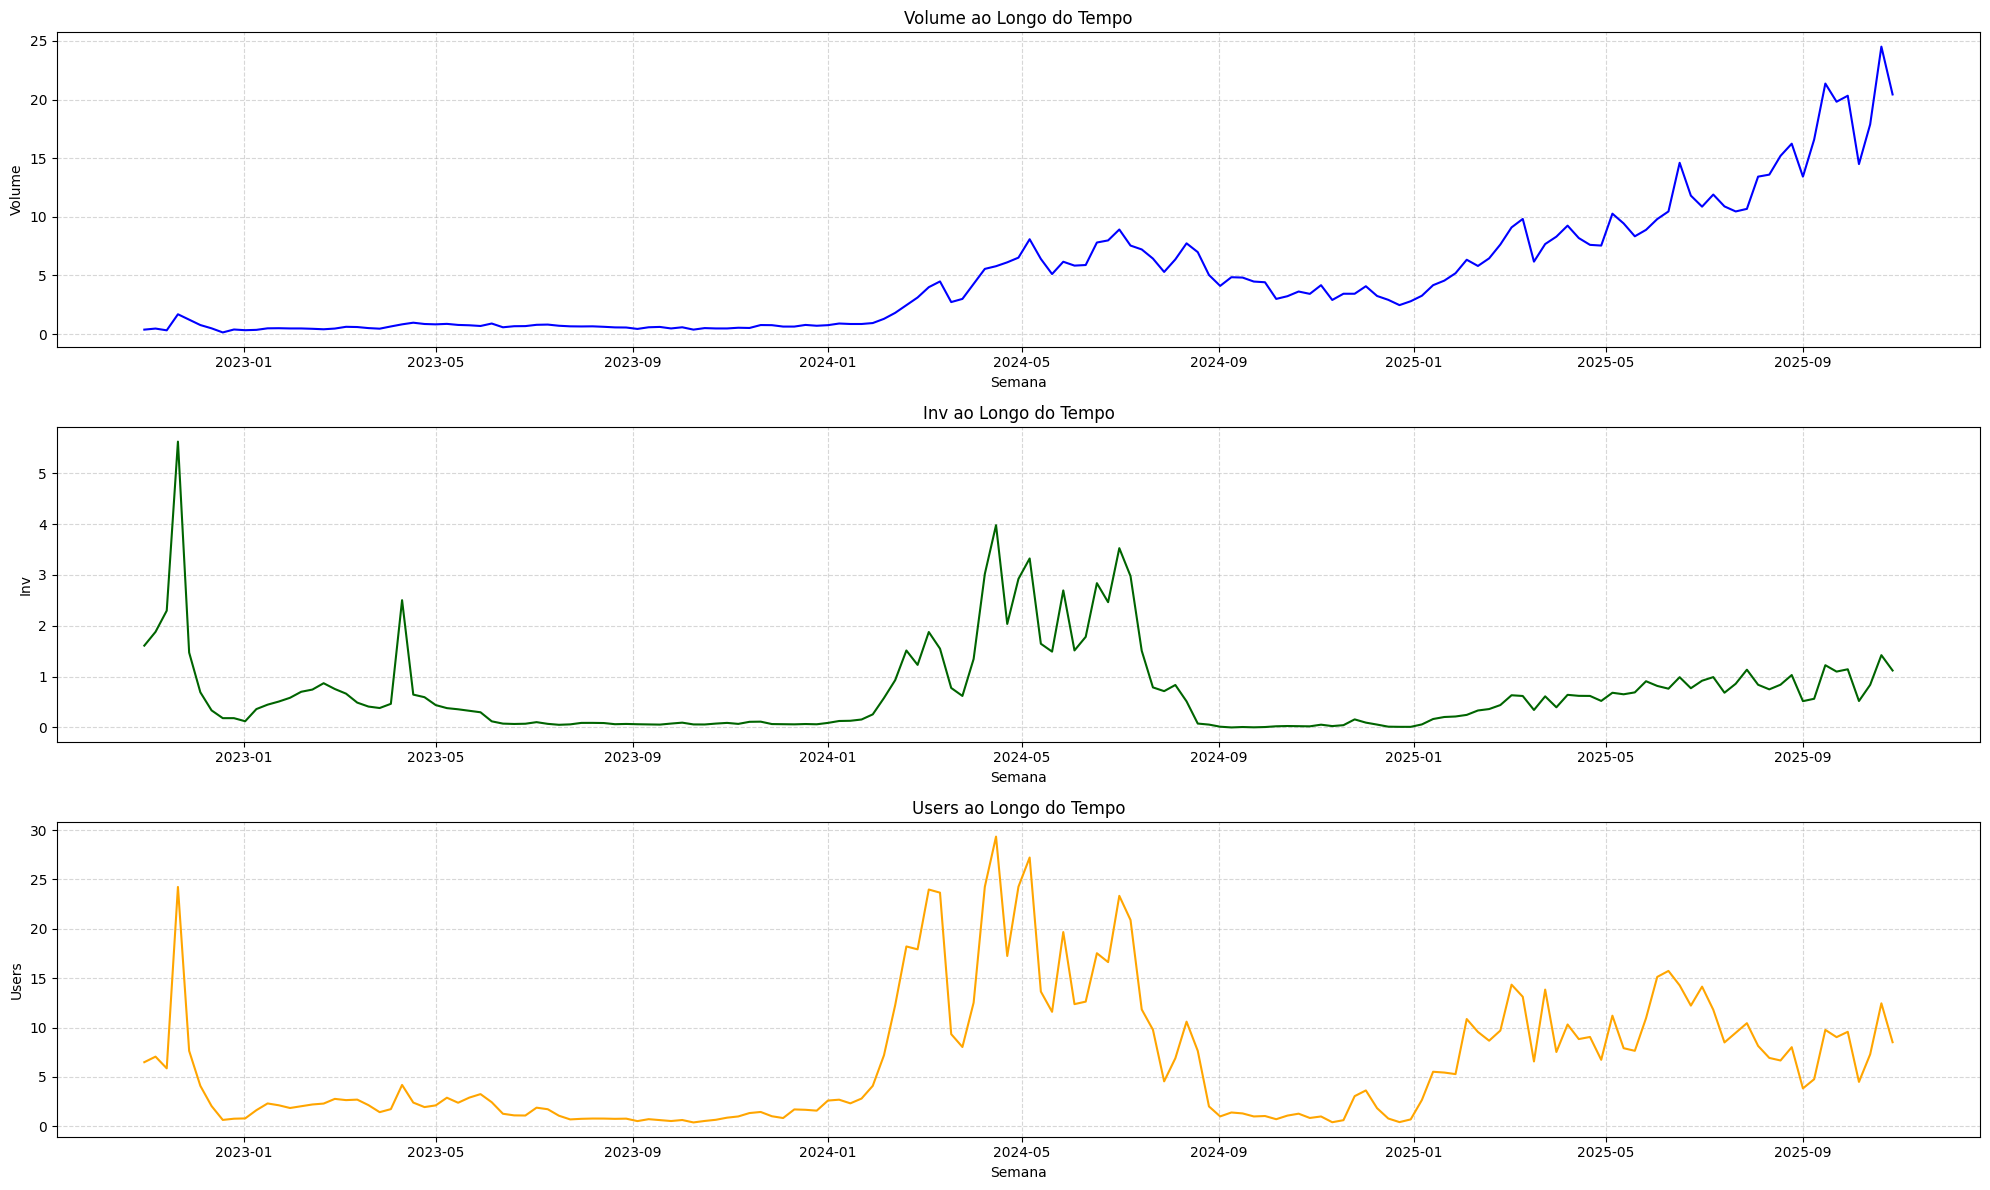

In [27]:
colors = ["blue", "darkgreen", "orange"]
columns = prison.columns

fig, axes = plt.subplots(3, 1, figsize=(20, 12))

for i in range(3):
    ax = axes[i]
    column = columns[i + 1]

    ax.plot(prison["week"], prison[column], linestyle="-", marker="", color=colors[i])

    # Labels e título
    ax.set_xlabel("Semana")
    ax.set_ylabel(column.title())
    ax.set_title(f"{column.title()} ao Longo do Tempo")

    # Estilo minimalista
    ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

# Baselines

In [ ]:
y = prison.sort_values("week").set_index("week")["volume"]
y = y.asfreq(pd.infer_freq(y.index) or "W")

h = 52  # horizonte
y_tr, y_te = y.iloc[:-h], y.iloc[-h:]

## Baselines padrão

**Mean**: média simples de todos os dados históricos.

**Naive**: usa simplesmente o último valor observado como previsão.

**Snaive**: usa o último valor observado da mesma estação.

**Drift**: tendência linear baseada no primeiro e no último valor da série.

In [ ]:
fh = ForecastingHorizon(np.arange(1, h + 1), is_relative=True)

def fit_pred(strategy, sp=1):
    f = NaiveForecaster(strategy=strategy, sp=sp)
    f.fit(y_tr)
    return f.predict(fh)

## Modelos de Suavização

**SES (Simple Exponential Smoothing)**: média ponderada dos valores passados, com maior peso nos mais recentes.

**Holt**: extensão do SES que adiciona uma tendência linear suavizada.

**Holt-Winters**: versão completa que incorpora tendência e sazonalidade (aditiva ou multiplicativa).


In [ ]:
# Suavização Exponencial Simples
ses_model = ExponentialSmoothing(y_tr, trend=None, seasonal=None)
ses_fit = ses_model.fit()
ses_pred = ses_fit.forecast(h)

# Holt
holt_model = ExponentialSmoothing(y_tr, trend="add", seasonal=None)
holt_fit = holt_model.fit()
holt_pred = holt_fit.forecast(h)

# Holt-Winters adaptativo 
hw_model = ExponentialSmoothing(y_tr, trend="add", seasonal="add", seasonal_periods=52)
hw_fit = hw_model.fit()
hw_pred = hw_fit.forecast(h)

# Holt-Winters multiplicativo
hw_mul_model = ExponentialSmoothing(y_tr, trend="add", seasonal="mul", seasonal_periods=52)
hw_mul_fit = hw_mul_model.fit()
hw_mul_pred = hw_mul_fit.forecast(h)

## Terando e comparando as Baselines

In [ ]:
target_name = y_te.name

preds = {
    "mean":  fit_pred("mean", sp=1),
    "naive": fit_pred("last", sp=1),
    "snaive": fit_pred("last", sp=52),   # sazonal 
    "drift": fit_pred("drift", sp=1),
    "ses": pd.Series(ses_pred, index=y_te.index, name=target_name),
    "Holt": pd.Series(holt_pred, index=y_te.index, name=target_name),
    "Holt-Winters Adaptativo": pd.Series(hw_pred, index=y_te.index, name=target_name),
    "Holt-Winters Multiplicativo": pd.Series(hw_mul_pred, index=y_te.index, name=target_name)
}

mase_metric = MeanAbsoluteScaledError(sp=52)  

rows = []
for name, yhat in preds.items():
    rows.append({
        "model": name,
        "MAE":  mean_absolute_error(y_te, yhat),
        "RMSE": mean_squared_error(y_te, yhat, square_root=True),
        "MAPE_%": mean_absolute_percentage_error(y_te, yhat) * 100,
        "MASE": mase_metric(y_te, yhat, y_train=y_tr),
    })

baseline_metrics = pd.DataFrame(rows).sort_values("RMSE").round(3)
baseline_metrics

,model,MAE,RMSE,MAPE_%,MASE
7,Holt-Winters Multiplicativo,3.794,6.030,33.565,1.101
6,Holt-Winters Adaptativo,4.696,6.678,37.940,1.363
2,snaive,5.782,7.422,58.712,1.678
3,drift,5.815,7.570,48.649,1.688
5,Holt,5.815,7.570,48.649,1.688
4,ses,6.538,8.424,54.465,1.898
1,naive,6.538,8.424,54.465,1.898
0,mean,7.526,9.292,66.304,2.185


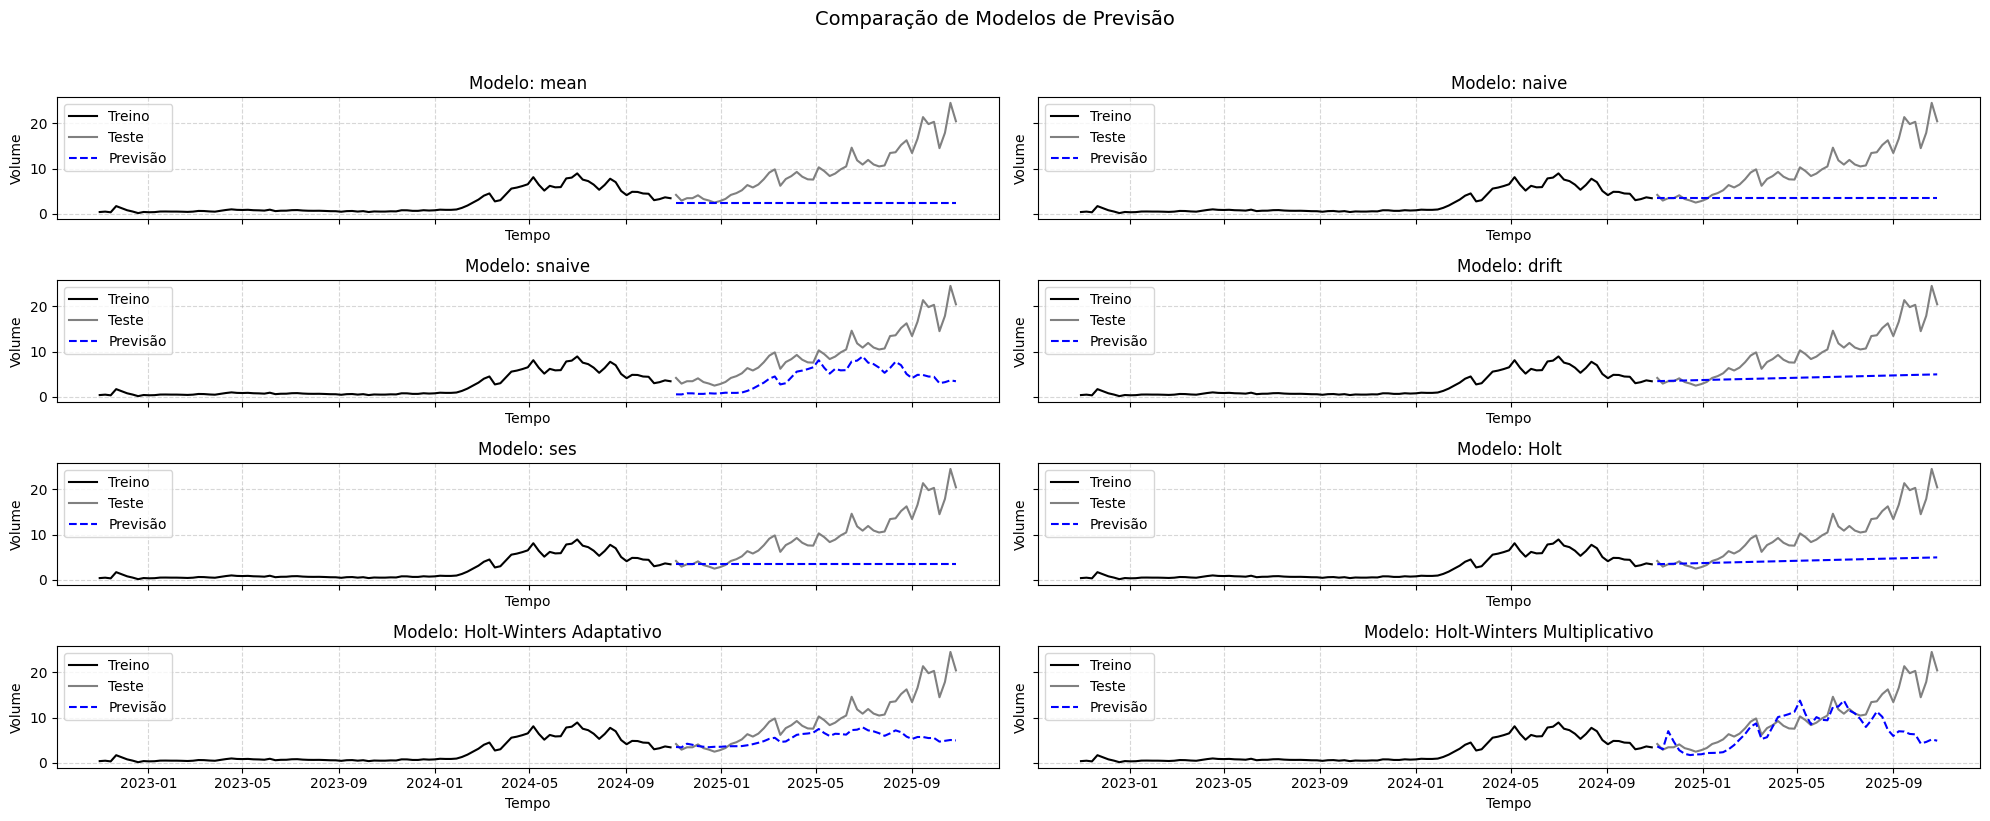

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(20, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i, (name, yhat) in enumerate(preds.items()):
    ax = axes[i]
    # Série observada (treino + teste)
    ax.plot(y_tr.index, y_tr, color="black", label="Treino")
    ax.plot(y_te.index, y_te, color="gray", label="Teste")
    # Previsão
    ax.plot(y_te.index, yhat, color="blue", linestyle="--", label="Previsão")
    
    ax.set_title(f"Modelo: {name}")
    ax.set_xlabel("Tempo")
    ax.set_ylabel("Volume")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()

plt.suptitle("Comparação de Modelos de Previsão", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Modelagem com ARIMA e SARIMA

In [ ]:
X = prison.sort_values("week").set_index("week")[["inv", "users"]]
X = X.asfreq(pd.infer_freq(y.index) or "W")

h = 52

y_tr, y_te = y.iloc[:-h], y.iloc[-h:]
X_tr, X_te = X.loc[y_tr.index], X.loc[y_te.index]


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# escolha inicial de (p, d, q)
d = 1  # diferenciar para remover tendência
p, q = 1, 1  # ponto de partida simples
# Futuramente podemos fazer um grid search para ver quais os melhores parametros

arima = ARIMA(y_tr, order=(p, d, q)).fit()
arima_pred = arima.forecast(steps=h)

arima_metrics = [{
    "model": "ARIMA",
    "MAE":  mean_absolute_error(y_te, arima_pred),
    "RMSE": mean_squared_error(y_te, arima_pred, square_root=True),
    "MAPE_%": mean_absolute_percentage_error(y_te, arima_pred) * 100,
    "MASE": mase_metric(y_te, arima_pred, y_train=y_tr),
}]

arima_metrics = pd.DataFrame(arima_metrics).round(3)

metrics = pd.concat([baseline_metrics, arima_metrics]).sort_values("RMSE").reset_index()
metrics = metrics.drop(columns="index")
metrics

c:\Users\alexa\AppData\Local\Programs\Python\Python313\Lib\site-packages\sktime\performance_metrics\forecasting\_base.py:671: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


,model,MAE,RMSE,MAPE_%,MASE
0,Holt-Winters Multiplicativo,3.794,6.030,33.565,1.101
1,Holt-Winters Adaptativo,4.696,6.678,37.940,1.363
2,snaive,5.782,7.422,58.712,1.678
3,drift,5.815,7.570,48.649,1.688
4,Holt,5.815,7.570,48.649,1.688
5,ARIMA,6.535,8.421,54.438,1.897
6,naive,6.538,8.424,54.465,1.898
7,ses,6.538,8.424,54.465,1.898
8,mean,7.526,9.292,66.304,2.185


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (1, 1, 1)
seasonal_order = (1, 1, 1, 52)

sarima = SARIMAX(y_tr, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False).fit()
sarima_pred = sarima.forecast(steps=h)

sarima_metrics = [{
    "model": "SARIMA",
    "MAE":  mean_absolute_error(y_te, sarima_pred),
    "RMSE": mean_squared_error(y_te, sarima_pred, square_root=True),
    "MAPE_%": mean_absolute_percentage_error(y_te, sarima_pred) * 100,
    "MASE": mase_metric(y_te, sarima_pred, y_train=y_tr),
}]

sarima_metrics = pd.DataFrame(sarima_metrics).round(3)

metrics = pd.concat([metrics, sarima_metrics]).sort_values("RMSE").reset_index()
metrics = metrics.drop(columns="index")
metrics

c:\Users\alexa\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\alexa\AppData\Local\Programs\Python\Python313\Lib\site-packages\sktime\performance_metrics\forecasting\_base.py:671: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


,model,MAE,RMSE,MAPE_%,MASE
0,SARIMA,3.262,5.461,25.376,0.947
1,Holt-Winters Multiplicativo,3.794,6.030,33.565,1.101
2,Holt-Winters Adaptativo,4.696,6.678,37.940,1.363
3,snaive,5.782,7.422,58.712,1.678
4,Holt,5.815,7.570,48.649,1.688
5,drift,5.815,7.570,48.649,1.688
6,ARIMA,6.535,8.421,54.438,1.897
7,naive,6.538,8.424,54.465,1.898
8,ses,6.538,8.424,54.465,1.898
9,mean,7.526,9.292,66.304,2.185


In [ ]:
sarimax = SARIMAX(
    y_tr,
    exog=X_tr,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 52),
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit()

sarimax_pred = sarimax.forecast(steps=h, exog=X_te)
sarimax_pred = pd.Series(sarimax_pred, index=y_te.index, name=y_te.name)

sarimax_metrics = [{
    "model": "SARIMAX",
    "MAE":  mean_absolute_error(y_te, sarimax_pred),
    "RMSE": mean_squared_error(y_te, sarimax_pred, square_root=True),
    "MAPE_%": mean_absolute_percentage_error(y_te, sarimax_pred) * 100,
    "MASE": mase_metric(y_te, sarimax_pred, y_train=y_tr),
}]

sarimax_metrics = pd.DataFrame(sarimax_metrics).round(3)

metrics = pd.concat([metrics, sarimax_metrics]).sort_values("RMSE").reset_index()
metrics = metrics.drop(columns="index")
metrics

c:\Users\alexa\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


,model,MAE,RMSE,MAPE_%,MASE
0,SARIMAX,3.146,5.195,24.256,0.913
1,SARIMA,3.262,5.461,25.376,0.947
2,Holt-Winters Multiplicativo,3.794,6.030,33.565,1.101
3,Holt-Winters Adaptativo,4.696,6.678,37.940,1.363
4,snaive,5.782,7.422,58.712,1.678
5,Holt,5.815,7.570,48.649,1.688
6,drift,5.815,7.570,48.649,1.688
7,ARIMA,6.535,8.421,54.438,1.897
8,naive,6.538,8.424,54.465,1.898
9,ses,6.538,8.424,54.465,1.898


# Medindo Correlações

*LEMBRAR DE MUDAR A POSIÇÃO DESSA SEÇÃO DE ACORDO COM A NECESSIDADE

In [ ]:
corr_pearson_matrix = prison[["volume", "inv", "users"]].corr("pearson")
corr_spearman_matrix = prison[["volume", "inv", "users"]].corr("spearman")
cross_corr_us_x_vol = sm.tsa.stattools.ccf(y, X["users"], adjusted=False)[:20]  # até 20 defasagens
cross_corr_inv_x_vol = sm.tsa.stattools.ccf(y, X["inv"], adjusted=False)[:20]

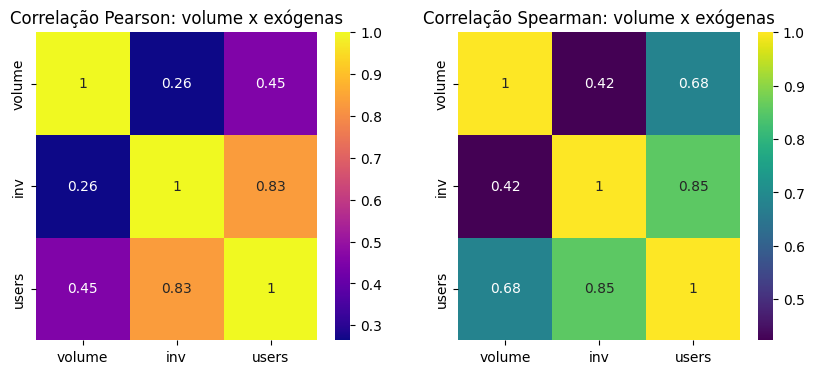

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(corr_pearson_matrix, ax=axes[0], annot=True, cmap="plasma")
axes[0].set_title("Correlação Pearson: volume x exógenas")

sns.heatmap(corr_spearman_matrix, ax=axes[1], annot=True, cmap="viridis")
axes[1].set_title("Correlação Spearman: volume x exógenas")

plt.show()


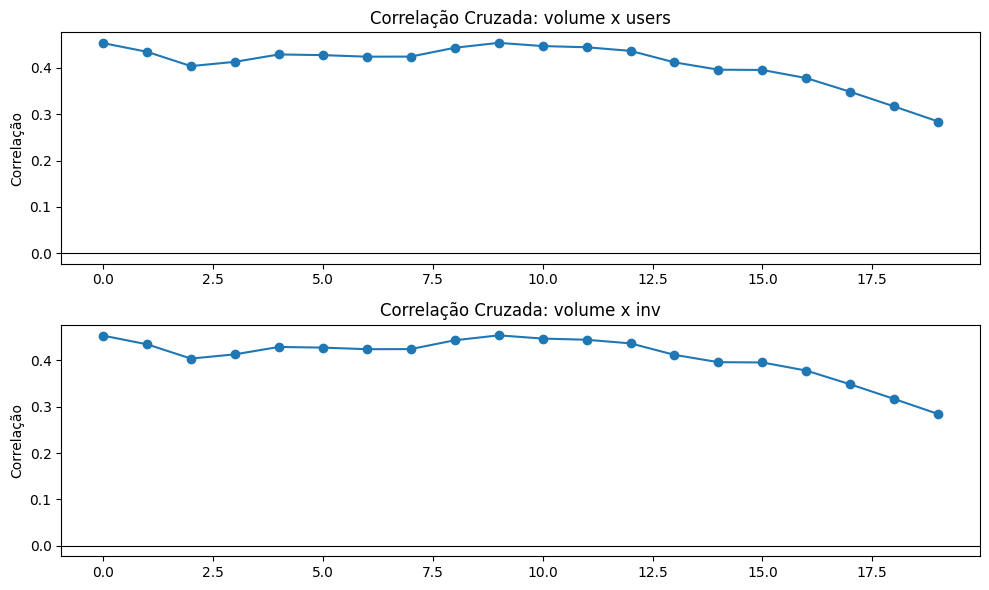

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# cross-correlation até 20 defasagens
cross_corr_us_x_vol = sm.tsa.stattools.ccf(y, X["users"], adjusted=False)[:20]
cross_corr_inv_x_vol = sm.tsa.stattools.ccf(y, X["inv"], adjusted=False)[:20]

axes[0].plot(range(len(cross_corr_us_x_vol)), cross_corr_us_x_vol, marker="o")
axes[0].axhline(0, color="black", linewidth=0.8)
axes[0].set_title("Correlação Cruzada: volume x users")
axes[0].set_ylabel("Correlação")

axes[1].plot(range(len(cross_corr_inv_x_vol)), cross_corr_inv_x_vol, marker="o")
axes[1].axhline(0, color="black", linewidth=0.8)
axes[1].set_title("Correlação Cruzada: volume x inv")
axes[1].set_ylabel("Correlação")

plt.tight_layout()
plt.show()
